# A) Visualisation et Prétraitement des données 



In [70]:
pip install pandas matplotlib

4413.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"

data = pd.read_csv(file_path)


# Données Brutes sous format Tableau 

In [19]:

import pandas as pd
# Renommer les colonnes en tenant compte de leur nombre
data.columns = ['Temps', 'X', 'Y', 'Z']  # Ajoutez un nom pour chaque colonne présente

# Convertir la colonne 'Temps' en datetime 
data['Temps'] = pd.to_datetime(data['Temps'])

# Calculer le temps écoulé en secondes entre chaque ligne
data['Temps écoulé (s)'] = data['Temps'].diff().dt.total_seconds().fillna(0)

# Créer une nouvelle colonne pour le temps cumulé croissant
data['Temps cumulé (s)'] = data['Temps écoulé (s)'].cumsum()

# Afficher les premières lignes pour vérifier
data.head()



,Temps,X,Y,Z,Temps écoulé (s),Temps cumulé (s)
0,2024-10-06 15:39:03.100,0.234375,-0.703125,0.093750,0.000,0.000
1,2024-10-06 15:39:03.102,0.281250,-0.765625,0.093750,0.002,0.002
2,2024-10-06 15:39:03.105,0.281250,-0.765625,0.109375,0.003,0.005
3,2024-10-06 15:39:03.107,0.234375,-0.781250,0.109375,0.002,0.007
4,2024-10-06 15:39:03.110,0.234375,-0.781250,0.093750,0.003,0.010


## Données Brutes au cours du temps (s)

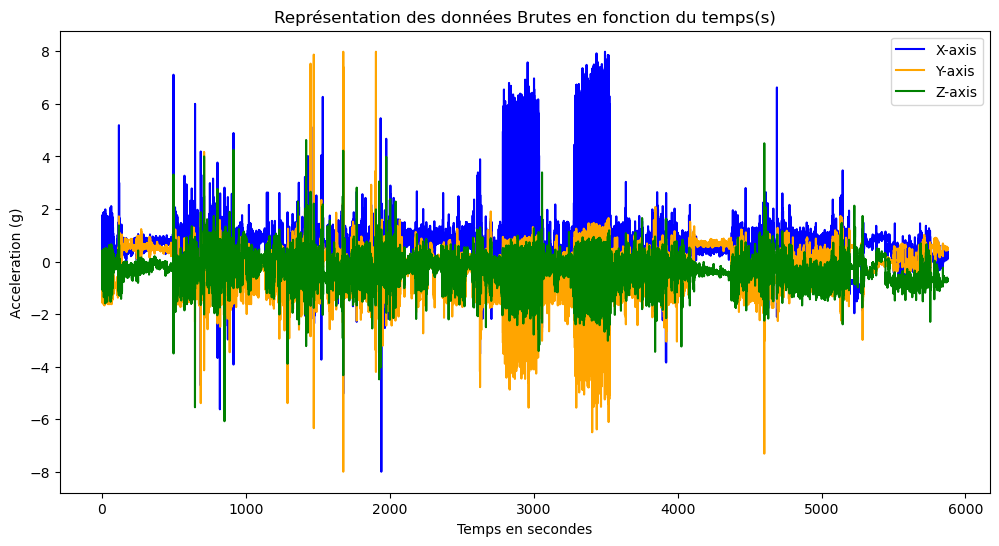

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"
data = pd.read_csv(file_path)


timestamp_column = data.columns[0]
signal_columns = data.columns[1:4]  # Sélectionner uniquement les colonnes 1, 2 et 3 pour le signal (X, Y, Z)

# Convertir la colonne de timestamps en datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')

# Supprimer les lignes avec des timestamps non valides
data = data.dropna(subset=[timestamp_column])

# Renommer les colonnes pour une meilleure clarté
data.columns = ['Temps', 'X', 'Y', 'Z']

# Convertir la colonne 'Temps' en datetime
data['Temps'] = pd.to_datetime(data['Temps'])


if len(data) > 1:
    # Calculer l'intervalle d'échantillonnage en secondes
    sampling_interval = (
        data['Temps'].iloc[1] - data['Temps'].iloc[0]
    ).total_seconds()
else:
    raise ValueError("Le fichier contient moins de deux entrées valides pour calculer l'intervalle d'échantillonnage.")

# Créer une colonne pour le temps relatif en secondes
data['relative_time_seconds'] = data.index * sampling_interval

# Définir les étiquettes des axes et les couleurs
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'blue', 'Y': 'orange', 'Z': 'green'}

# Tracer le signal
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(['X', 'Y', 'Z'], axis_labels, colors.values()):  # Utiliser uniquement X, Y, Z
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label, color=color)

plt.title("Représentation des données Brutes en fonction du temps(s)")
plt.xlabel("Temps en secondes")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.show()


## Prétraitement des données : Application d'un filtre passe bas  de butterworth :

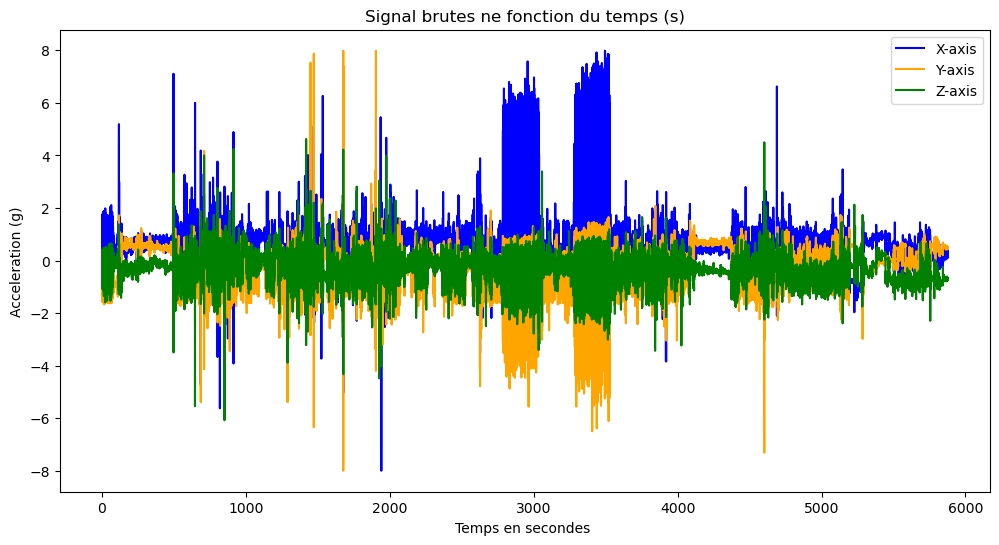

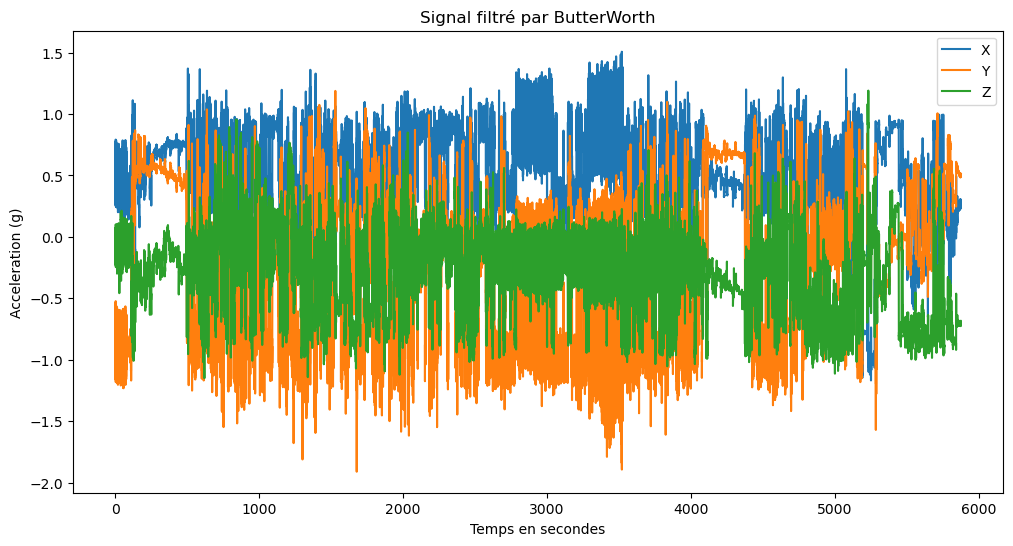

In [27]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path to the dataset
file_path = r"/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates

# Calculate the sampling interval (in seconds) based on the time difference between two consecutive rows
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()
# Create a new column for relative time in seconds, using the data index and sampling interval
data['relative_time_seconds'] = data.index * sampling_interval

# Define labels for the X, Y, and Z axes 
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'blue', 'Y': 'orange', 'Z': 'green'}  # Define colors for each signal

# Plot the signal with the correct label and color to each axis. using a loop
plt.figure(figsize=(12, 6))
for signal, axis_label, color in zip(signal_columns, axis_labels, colors.values()):
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label, color=color)

# Add a title, axis labels, and a legend 
plt.title("Signal brutes ne fonction du temps (s)")
plt.xlabel("Temps en secondes ")
plt.ylabel("Acceleration (g)")
plt.legend() # Display the legend
plt.show()

# Import functions for filtering signals
from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    # Calculate the Nyquist frequency, which is half the sampling frequency
    nyquist = 0.5 * fs  
    normal_cutoff = cutoff / nyquist
    # Create the Butterworth filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
     # Apply the filter to the data 
    return filtfilt(b, a, data)

# Define the sampling frequency (fs) and cutoff frequency for the low-pass filter
fs = 1 / (sampling_interval)  # Sampling frequency in Hz
cutoff = 2  # Low-pass filter cutoff frequency in Hz
axis_labels = ['X', 'Y', 'Z']  # Labels for the signals, used in the plot legend

# Apply the filter directly to the original filtered_data DataFrame 
for signal in signal_columns: 
    data[signal] = lowpass_filter(data[signal], cutoff, fs) # Filter the signal 

# Plot the low-pass filtered signals directly from filtered_data
plt.figure(figsize=(12, 6)) # Set the figure size for better visualization
for signal, axis_label in zip(signal_columns, axis_labels):  # Use axis_labels for legend
    plt.plot(data['relative_time_seconds'], data[signal], label=axis_label)  # Plot each filtered signal

# Add plot title, axis labels, and legend
plt.title("Signal filtré par ButterWorth") # Title of the plot
plt.xlabel("Temps en secondes")
plt.ylabel("Acceleration (g)")
plt.legend()  # Display the legend
plt.show()

Ce filtre permet de : 

`Réduire le bruit` : Suppression des fluctuations parasites pour obtenir un signal plus propre.

`Lisser le signal ` : Simplifie le signal pour mettre en évidence les variations principales.

`Éliminer les artefacts` : Réduction des valeurs extrêmes dues à des erreurs de mesure.

`Mettre en évidence les mouvements significatifs` : Les tendances réelles sont plus faciles à repérer.

`Améliorer la lisibilité` : Facilite l'interprétation visuelle et l'analyse des données.
